In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [69]:
all_files = ['./data/sub_feat457_modelselect.csv',
             './data/sub_feat454_rmcardid_modelselect.csv',
            './data/sub_feat448_modelselect.csv']

In [113]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
all_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "sub" + str(x), range(len(all_sub.columns))))
all_sub.columns = cols
all_sub.reset_index(inplace=True)

In [114]:
all_sub.head()

,TransactionID,sub0,sub1,sub2
0,3663549,0.001578,0.000918,0.000366
1,3663550,0.000631,0.001581,0.001019
2,3663551,0.001217,0.001058,0.000492
3,3663552,0.001046,0.000984,0.000427
4,3663553,0.000626,0.001002,0.000398


In [115]:
# calculate correlation of submissions
corr = all_sub.iloc[:,1:].corr()

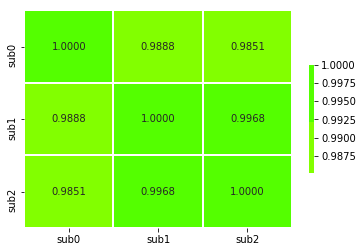

In [116]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [117]:
corr_rank = np.tril(all_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(corr.shape),1)
corr_rank

array([[1.        , 1.        , 1.        ],
       [0.98879574, 1.        , 1.        ],
       [0.98506865, 0.99680381, 1.        ]])

In [118]:
# calculate how many times of blend is needed
blend_times = (corr_rank>0).sum() - (corr_rank>0.99).sum()
blend_times

2

In [119]:
m_gmean, weight_sum = 0, 0

In [120]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean
for i in range(blend_times):
    min_corr_indexs = np.unravel_index(corr_rank.argmin(), corr_rank.shape)
    print('%s round with current minimual index%s'%(i,min_corr_indexs))
    # weight decay with higher correlations
    weight = (blend_times-i)/blend_times
    m_gmean += weight*(np.log(all_sub.iloc[:,min_corr_indexs[0]+1])+np.log(all_sub.iloc[:,min_corr_indexs[1]+1]))/2
    print(m_gmean.head())
    weight_sum += weight
    print('current weight:%s, total weight:%s'%(weight,weight_sum))
    corr_rank[min_corr_indexs] = 1
    print(corr_rank)

0 round with current minimual index(2, 0)
0   -7.182680
1   -7.128428
2   -7.163772
3   -7.310355
4   -7.603249
dtype: float64
current weight:1.0, total weight:1.0
[[1.         1.         1.        ]
 [0.98879574 1.         1.        ]
 [1.         0.99680381 1.        ]]
1 round with current minimual index(1, 0)
0   -10.543811
1   -10.582666
2   -10.554394
3   -10.756913
4   -11.173933
dtype: float64
current weight:0.5, total weight:1.5
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         0.99680381 1.        ]]


In [121]:
m_gmean = np.exp(m_gmean/weight_sum)
m_gmean.head()

0    0.000886
1    0.000863
2    0.000879
3    0.000768
4    0.000582
dtype: float64

In [122]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.000780
1    0.000758
2    0.000774
3    0.000663
4    0.000476
dtype: float64

In [123]:
all_sub['isFraud'] = m_gmean
#concat_sub[['TransactionID','isFraud']].to_csv('./data/sub_stack_gmean.csv',index=False)

In [124]:
all_sub.tail()

,TransactionID,sub0,sub1,sub2,isFraud
506686,4170235,0.005848,0.007015,0.002817,0.004628
506687,4170236,0.002687,0.004152,0.002658,0.002777
506688,4170237,0.002786,0.005243,0.003182,0.003135
506689,4170238,0.002308,0.002355,0.001059,0.001682
506690,4170239,0.003451,0.003530,0.002144,0.002855
